In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import moleculetools as mt
import seaborn as sns
import plot_utils as pu
import re

%matplotlib inline

pu.set_styles()

In [11]:
class System:
    def __init__(self, *args, **kwargs):
        self.name = kwargs.get('name', "system")
        self.ints = {}
        print("System instantiated!\n")
        
    def get_wn(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.wn = []
        for i in range(len(lines)):
            line = lines[i]
            if "Frequencies --" in line:
                self.wn += [float(x) for x in line.split()[2:]]
            else:
                pass
        
    def load_raman(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.ints['SL'] = []
        for i in range(len(lines)):
            line = lines[i]
            if "Raman Activ --" in line:
                self.ints['SL'] += [float(x) for x in line.split()[3:]]
            else:
                pass
    
    def load_uv(self, filename):
        with open(filename, 'r') as openfile:
            full = openfile.read()
            lines = openfile.readlines()
        
        nstates = re.search(r'(?<=nstates\=)\d+', full).group(0)
        states = re.findall(r'(?<=Excited State).*(?=\<\S\*\*2\>)', full)
        self.uv_data = {}
        for state in states:
            state_n = int(state.split()[0].split(':')[0])
            nm = float(state.split()[4])
            f = float(state.split()[6].split('=')[-1])
            self.uv_data[state_n] = {}
            self.uv_data[state_n]['nm'] = nm
            self.uv_data[state_n]['f'] = f
            
    def load_rr(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        tmp = []
        in_wl = float(filename.split('nm')[0][-3:])
        for i in range(len(lines)):
            line = lines[i]
            if "RamAct Fr= 1--" in line:
                tmp += [float(x) for x in line.split("--")[1].split()]
            elif "Using perturbation frequencies:" in line:
                in_wl = round(45.56335/float(line.split(':')[1].strip()))
            else:
                pass
        self.ints["{}nm".format(in_wl)] = tmp
        
    def load_intmodes(self, filename, mol_atoms):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        rawmodes = []
        reading_mode = False
        for i in range(len(lines)):
            line = lines[i]
            if "Normal Mode" in line:
                reading_mode = True
                mode_start = i
            elif "-"*80 in line and reading_mode and i - mode_start > 3:
                mode_end = i
                rawmodes.append(lines[mode_start+4:mode_end])
                reading_mode = False
            else:
                pass

        self.intmodes = {'mol%':[], 'mix%':[], 'sur%':[]}
        for mode in rawmodes:
            mol, mix, sur = (0, 0, 0)
            for vib in mode:
                vib_parts = vib.split()
                desc = vib_parts[2]
                atom_substring = desc[desc.find('(')+1:desc.find(')')]
                atoms = [int(x) for x in atom_substring.split(',')]
                value = float(vib_parts[3])

                if all(i in mol_atoms for i in atoms):
                    mol += abs(value)
                elif any(i in mol_atoms for i in atoms):
                    mix += abs(value)
                else:
                    sur += abs(value)

            total = (mol + mix + sur)/100
            wmol, wmix, wsur = np.array([mol, mix, sur])/total
            self.intmodes['mol%'].append(wmol)
            self.intmodes['mix%'].append(wmix)
            self.intmodes['sur%'].append(wsur)

            
def make_df(system):
    df = pd.concat([pd.DataFrame(data=np.arange(1, len(system.wn) + 1), columns=['mode']),
                    pd.DataFrame(data=system.wn, columns=['wn']),
                    pd.DataFrame(data=system.intmodes),
                    pd.DataFrame(data=system.ints)],
                   axis=1)
    df.set_index('mode', inplace=True)
    try:
        nm_cols = [col for col in df.columns if "nm" in col]
        other_cols = [col for col in df.columns if col not in nm_cols]
        new_col_list = other_cols + sorted(nm_cols, key=lambda x:x[:3])
        df = df[new_col_list]
        nm_cols = [col for col in df.columns if "nm" in col]
        for col in nm_cols:
            df['{} ef'.format(col)] = np.log10(df[col]/df['SL'])
        ef_cols = [col for col in df.columns if "ef" in col]
        other_cols = [col for col in df.columns if col not in ef_cols]
        new_col_list = other_cols + sorted(ef_cols, key=lambda x:x[:3])
        df = df[new_col_list]
    except:
        print('Error! Check make_df()')
    print(df.head())
    print(df.info())
    return df


def plot_uv(system=None, xlim='auto', main_color=pu.colors['color1'], linestyle='-', states_to_plot=None, height=5, f=None, ax=None, label=None):
    if f == None and ax == None:
        f, ax = pu.new_figure(height=height, type='body')

    all_nm = [system.uv_data[state]['nm'] for state in system.uv_data.keys()]
    all_f = [system.uv_data[state]['f'] for state in system.uv_data.keys()]

    margin = (max(all_nm) - min(all_nm))*0.05
    if xlim == 'auto':
        xmin = np.where(min(all_nm) - margin >= 0, min(all_nm) - margin, 0)
        xmin = np.floor(xmin/50)*50
        xmax = np.where(max(all_nm) + margin >= 0, max(all_nm) + margin, 0)
        xmax = np.ceil(xmax/50)*50
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$\lambda$ (nm)')
    ax.set_ylabel(r'$\varepsilon$ (L mol$^{-1}$ cm$^{-1}$)')

    uv_preexp = 40489.9942104
    uv_sigma = 0.000322622
    all_nm = [1/nm for nm in all_nm]
    points, gaussians = calculate_envelope(x=all_nm,
                                           y=all_f,
                                           preexp=uv_preexp,
                                           sigma=uv_sigma,
                                           xrange=xlim,
                                           inverse=True)

    if states_to_plot != None:
        
        if type(states_to_plot) == list:
            pass

        elif type(states_to_plot) == int:
            f_values = np.array(all_f)
            state_and_f = list(zip(range(1, len(f_values) + 1), f_values))
            sorted_state_and_f = sorted(state_and_f, key=lambda x:x[1], reverse=True)
            print(sorted_state_and_f)
            states_to_plot = [sf[0] for sf in sorted_state_and_f[:states_to_plot]]
            #states_to_plot = f_values.argsort()[-states_to_plot:][::-1]
            #states_to_plot = [s + 1 for s in states_to_plot]
            
        print(states_to_plot)
        
        for i, state in enumerate(states_to_plot):
            color_list = list(pu.colors.values())[1:]
            #sns.lineplot(points, gaussians[state - 1], linestyle='--', ax=ax)
            ax.plot(points, gaussians[state - 1], linestyle='--', color=color_list[i])
            ax.text(x = system.uv_data[state]['nm'],
                    y = max(gaussians[state - 1]) + max(gaussians.sum(axis=0))*0.02,
                    s = "{} nm".format(system.uv_data[state]['nm']),
                    ha = 'center', color=color_list[i])
            
    
    #sns.lineplot(points, gaussians.sum(axis=0), ax=ax, color=main_color, linestyle=linestyle)
    ax.plot(points, gaussians.sum(axis=0), color=main_color, linestyle=linestyle)#, label=label)
    pu.tuftefy(ax)
    return f, ax

def make_df(system):
    df = pd.concat([pd.DataFrame(data=np.arange(1, len(system.wn) + 1), columns=['mode']),
                    pd.DataFrame(data=system.wn, columns=['wn']),
                    pd.DataFrame(data=system.intmodes),
                    pd.DataFrame(data=system.ints)],
                   axis=1)
    df.set_index('mode', inplace=True)
    try:
        nm_cols = [col for col in df.columns if "nm" in col]
        other_cols = [col for col in df.columns if col not in nm_cols]
        new_col_list = other_cols + sorted(nm_cols, key=lambda x:x[:3])
        df = df[new_col_list]
        nm_cols = [col for col in df.columns if "nm" in col]
        for col in nm_cols:
            df['{} ef'.format(col)] = np.log10(df[col]/df['SL'])
        ef_cols = [col for col in df.columns if "ef" in col]
        other_cols = [col for col in df.columns if col not in ef_cols]
        new_col_list = other_cols + sorted(ef_cols, key=lambda x:x[:3])
        df = df[new_col_list]
    except:
        print('Error! Check make_df()')
    print('Report')
    print('Surface % - min: {}  max: {}'.format(df['sur%'].min(), df['sur%'].max()))
    print('Molecule % - min: {}  max: {}'.format(df['mol%'].min(), df['mol%'].max()))      
    #print(df.head())
    #print(df.info())
    return df

def plot_hm(system, maxsur=75, minmol=25, minef=7, vmin=0, vmax=10, xrange=[0, 4000], cool_modes=None, cool_nm=None):
    nm_list = []
    spec_list = []
    sl_ints = system.ints['SL']
    points, sl_env = calculate_envelope(x=system.wn, y=sl_ints, npoints=10000, preexp=1, sigma=4, xrange=xrange, inverse=False)
    for k, v in sorted(system.ints.items(), key=lambda x:x[0][:3])[:-1]:
        nm_list.append(k)
        points, env = calculate_envelope(x=system.wn, y=v, npoints=10000, preexp=1, sigma=4, xrange=xrange, inverse=False)
        
        gaussians = env.sum(axis=0)
        gaussians = np.where(gaussians==0, 1, gaussians)
        
        sl_gaussians = sl_env.sum(axis=0)
        sl_gaussians = np.where(sl_gaussians==0, 1, sl_gaussians)
        
        div = gaussians/sl_gaussians
        spec_list.append(np.log10(div))
        
    f, ax = pu.new_figure(height=4.5, type='half-page')
    #sns.heatmap(data=np.array(spec_list), ax=ax)
    im = ax.imshow(np.array(spec_list), aspect='auto', interpolation='none')
    f.colorbar(im)
    
    df = make_df(system)
    if cool_modes == None:
        cool_modes = list(df[(df['sur%'] <= maxsur) & (df['mol%'] >= minmol)].index)
        print("cool_modes\n", cool_modes)
        
    if cool_nm == None:
        cool_nm = [col for col in df.columns if df[col].max() >= minef and "ef" in col]
        cool_nm = [int(nm[:3]) for nm in cool_nm]
        print("cool_nm\n", cool_nm)

    # Annotate modes
    xmin, xmax = ax.get_xlim()
    cool_mode_positions = []
    for mode in cool_modes:
        wn = system.wn[mode - 1]
        fraction = (wn - xrange[0])/(xrange[1] - xrange[0])
        position = fraction*(xmax - xmin)
        cool_mode_positions.append(position)
    ax.set_xticks(cool_mode_positions)
    ax.set_xticklabels([str(x) for x in cool_modes])
    
    # Annotate wavelengths
    ax.set_ylim([0, len(nm_list)])
    nm_list = [int(nm[:3]) for nm in nm_list]
    ymin, ymax = ax.get_ylim()
    print(ymin, ymax)
    cool_nm_positions = []
    for nm in cool_nm:
        fraction = (nm - min(nm_list))/(max(nm_list) - min(nm_list))
        position = fraction*(ymax - ymin)
        cool_nm_positions.append(position)
    ax.set_yticks(cool_nm_positions)
    ax.set_yticklabels([str(x) for x in cool_nm])
    
    # rotate tick labels
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', direction='out', color='#000000')
    
    pu.tuftefy(ax)
    
    # set spines as visible
    #for _, spine in ax.spines.items():
    #    spine.set_visible(True)
        
    return f, ax

def calculate_envelope(x, y, npoints=10000, preexp=1, sigma=1, xrange=[0, 4000], inverse=False):
    xspace = np.linspace(xrange[0], xrange[1], npoints)
    points = xspace
    if inverse == True:
        points = points**(-1)
    gaussians = []
    for pair in list(zip(x, y)):
        gaussians.append(pair[1]*preexp*np.exp(-np.square((points - pair[0])/sigma)))
    return xspace, np.array(gaussians)

def load_flower(nameid):
    system = System(name=nameid)
    system.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    return system

def load_complex(nameid):
    system = System(name=nameid)
    natoms = int(nameid[-2:])*3
    print('Number of atoms: {}'.format(natoms))
    system.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/uv-{}stx.out'.format(nameid, nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers-and-stx/single-raman/raman_{}stx.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers-and-stx/single-raman/raman_{}stx.log'.format(nameid))
    system.load_intmodes('/Users/oscar/Dropbox/s3/flowers-and-stx/single-intmodes/intmodes_{}stx.log'.format(nameid),
    mol_atoms = list(range(1, natoms + 1)))
    import glob
    path = '/Users/oscar/CALC/STX/sunflowers/flower-garden/rr/{}/*_FIX.log'.format(nameid)
    for rr in glob.glob(path):
        system.load_rr(rr)
    return system

def plot_raman(system=None, modes=None, xlim='auto', mode='SL', rr_list=None):
    f, ax = pu.new_figure(height=5, type='body')
    
    margin = (max(system.wn) - min(system.wn))*0.05
    if xlim == 'auto':
        xmin = np.where(min(system.wn) - margin >= 0, min(system.wn) - margin, 0)
        xmin = np.floor(xmin/100)*100
        xmax = np.where(max(system.wn) + margin >= 0, max(system.wn) + margin, 0)
        xmax = np.ceil(xmax/100)*100
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$\tilde{\nu}$ (cm$^{-1}$)')
    ax.set_ylabel(r'Intensity (a.u.)')

    raman_preexp = 1
    raman_sigma = 4
    
    if mode == 'skeleton':
        for i, wn in enumerate(system.wn):
            ax.plot([wn, wn], [0, system.ints['SL'][i]], color=pu.colors['color1'])
    
    if mode == 'SL':
        points, gaussians = calculate_envelope(x=system.wn, y=system.ints['SL'],
                                               preexp=raman_preexp, sigma=raman_sigma)
        ax.plot(points, gaussians.sum(axis=0), color=pu.colors['color1'])
        
    elif mode == 'multirr':
        if rr_list is not None:
            margin = 0.05
            envs = []
            for i, rr in enumerate(rr_list):
                points, gaussians = calculate_envelope(x=system.wn, y=system.ints['{}nm'.format(rr)],
                                                       preexp=raman_preexp, sigma=raman_sigma)
                envs.append(list(gaussians.sum(axis=0)))
            all_ints = list(sum(envs, []))
            max_int = max(all_ints)
            for i, env in enumerate(envs):
                env_color = list(pu.colors.values())[i + 1]
                ax.plot(points, env + max_int*i*(1 + margin), color=env_color)
                ax.text(x=xlim[1]*(1 - margin), y=max_int*i*(1 + margin) + max_int*margin, s='{} nm'.format(rr_list[i]), color=env_color)
            ax.set_ylabel('')
            ax.set_yticks([])
        else:
            pass

    if modes is not None:
        for mode in modes:
            ax.axvline(x=system.wn[mode - 1], ymin=0, ymax=1, color=pu.colors['color1'])
            ax.text(x=system.wn[mode - 1] + ax.get_xlim()[1]*0.005, y=ax.get_ylim()[1]*0.95, s=str(mode))

    pu.tuftefy(ax)
    return f, ax

System instantiated!

Number of atoms: 36
Report
Surface % - min: 0.0  max: 100.00000000000001
Molecule % - min: 0.0  max: 98.36636198710103
cool_modes
 [6, 17, 26, 27, 31, 32, 35, 36, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 56, 58, 61, 62, 75, 89, 90, 96, 98, 99, 101, 104, 105, 107, 110, 111, 112, 113, 115, 116, 118, 123, 125, 127, 128, 131, 132, 134, 136, 139, 140, 142, 143, 146, 154, 158, 159, 160, 161, 163, 167, 173, 175, 180, 183, 188, 192, 193, 194, 195]
cool_nm
 [336, 342, 360, 366, 372, 375, 408, 543, 549, 600, 639, 663, 696, 708, 738, 741, 795]
0.0 201.0


No handles with labels found to put in legend.


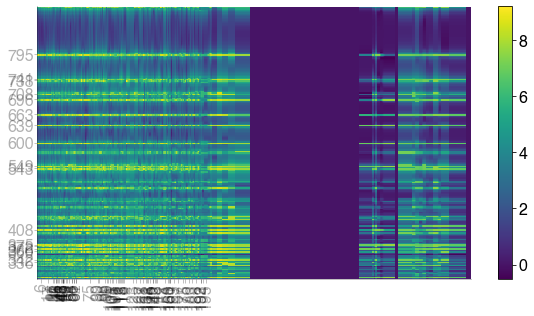

In [13]:
com = load_complex('as12')
f, ax = plot_hm(com, xrange=[0, 4000], maxsur=30, minmol=70, minef=9.2, vmax=10)

In [20]:
as12 = make_df(com)
as12.loc[42]

Report
Surface % - min: 0.0  max: 100.00000000000001
Molecule % - min: 0.0  max: 98.36636198710103


wn          229.284600
mol%         92.546882
mix%          7.453118
sur%          0.000000
SL           12.982800
               ...    
888nm ef      3.322571
891nm ef      3.678902
894nm ef      4.173102
897nm ef      4.947817
900nm ef      6.448369
Name: 42, Length: 407, dtype: float64

System instantiated!

Number of atoms: 36


No handles with labels found to put in legend.


0.0 201.0


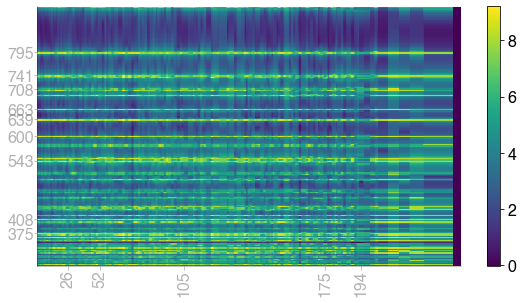

In [4]:
com = load_complex('as12')
f, ax = plot_hm(com, xrange=[0, 2000], maxsur=10, minmol=90, minef=9.2, vmax=10,
                cool_nm = [795, 741, 708, 663, 639, 600, 543, 408, 375],
                cool_modes = [26, 52, 105, 175, 194])
#pu.save_figure(f, '../images/comb-as12.png')

System instantiated!

Number of atoms: 36


No handles with labels found to put in legend.


(<Figure size 774x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114e31f60>)

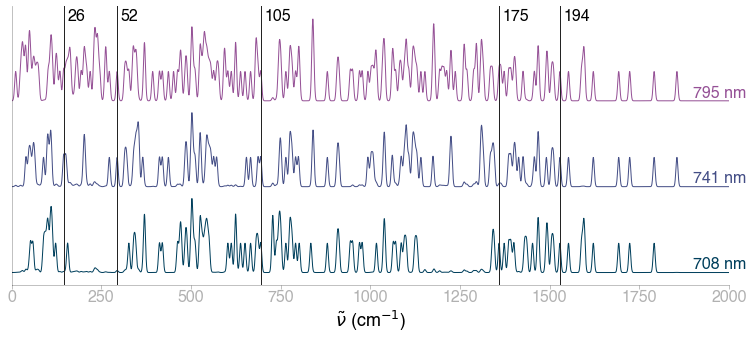

In [5]:
name = 'as12'
com = load_complex(name)
plot_raman(com, rr_list=[708, 741, 795], mode='multirr', xlim=[0, 2000], modes=[26, 52, 105, 175, 194])

System instantiated!



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


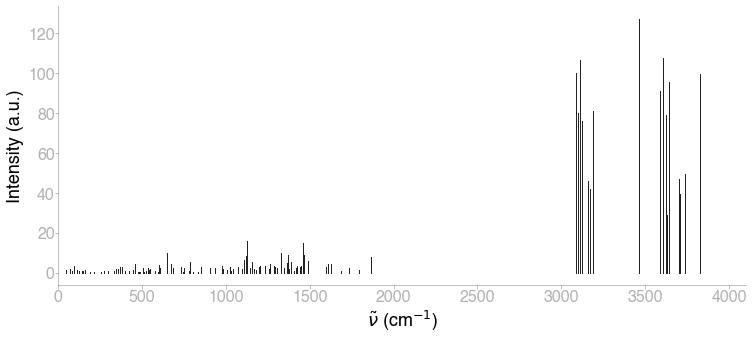

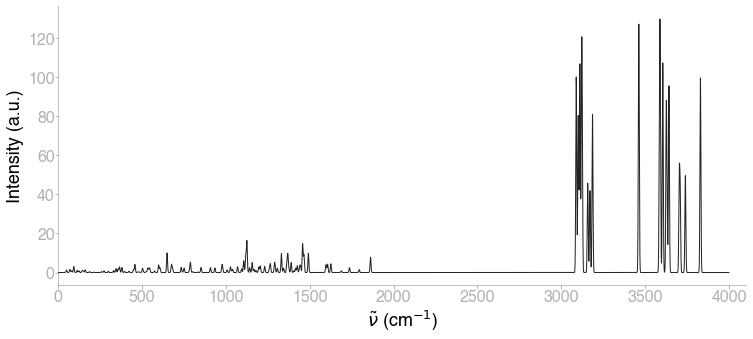

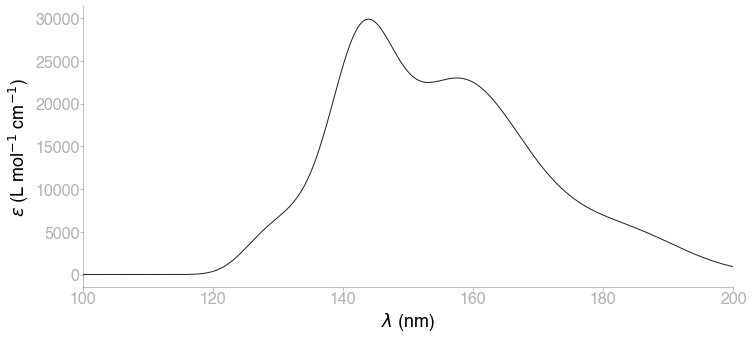

In [6]:
sys = System(name='STX')
sys.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/uv-stx.log')
sys.get_wn('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/raman-stx.log')
sys.load_raman('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/raman-stx.log')
f, ax = plot_raman(sys, mode='skeleton')
pu.save_figure(f, '../images/without-envelope.pdf')
f, ax = plot_raman(sys, mode='SL')
pu.save_figure(f, '../images/with-envelope.pdf')
f, ax = plot_uv(sys)
pu.save_figure(f, '../images/uv-envelope.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

[24, 30]


(<Figure size 774x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1154e8da0>)

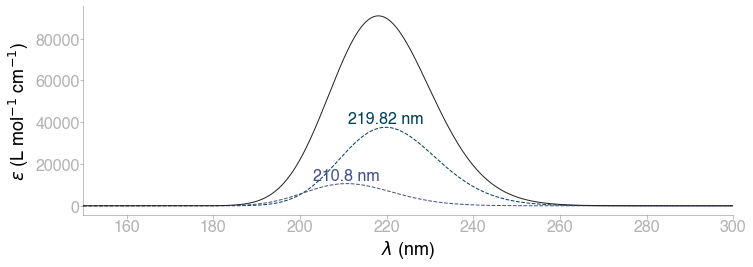

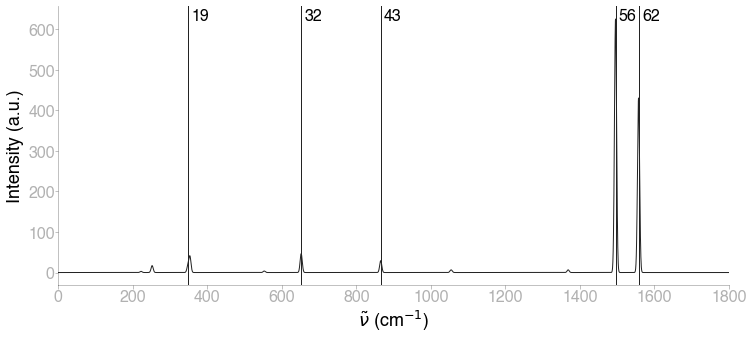

In [7]:
sys = load_flower('s08')
plot_uv(system=sys, states_to_plot=[24, 30], height=4)
plot_raman(system=sys, modes=[19, 32, 43, 56, 62])

/Users/oscar/miniconda3/envs/py_dev/lib/python3.7/site-packages/ipykernel_launcher.py:289: RuntimeWarning: divide by zero encountered in reciprocal
No handles with labels found to put in legend.


System instantiated!



(<Figure size 774x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11525f828>)

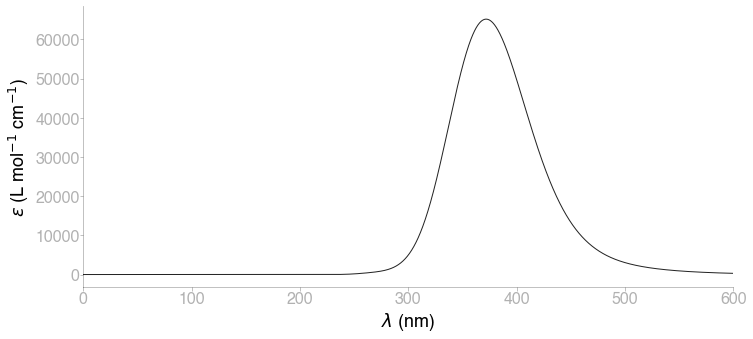

In [8]:
name = 'asn08'
com = System(name=name)
com.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/uv-{}stx.out'.format(name))
plot_uv(com, xlim=[0, 600])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

System instantiated!

System instantiated!

System instantiated!



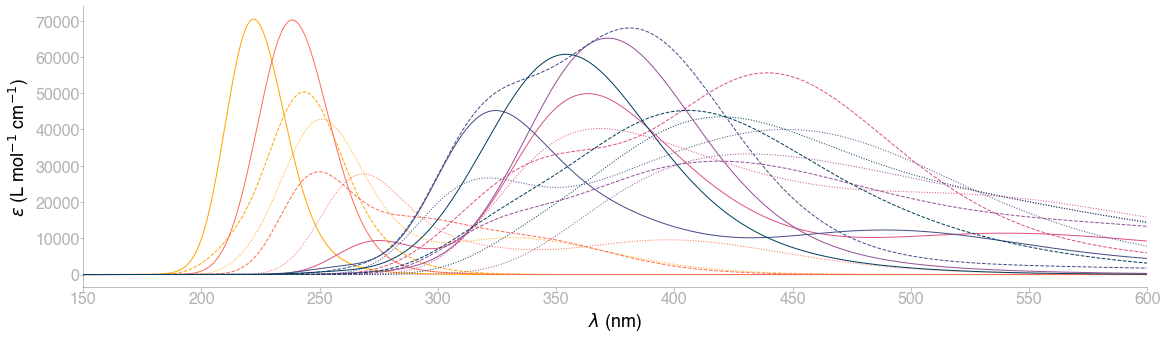

In [9]:
def plot_uv_list(sys_list, petal_list, good_threshold=300):
    uv_list = [a + b for a in sys_list for b in petal_list]
    f, ax = pu.new_figure(height=5, type='wide')
    for sys in sys_list:
        for petals in petal_list:
            name = sys + petals
            com = System(name=name)
            com.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/uv-{}stx.out'.format(name, name))
            #com.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(name))
            f, ax = plot_uv(com, f=f, ax=ax, main_color=pu.sys_colors[sys],
                            xlim=[150, 600], linestyle=pu.petal_styles[petals], label=name)
    #ax.fill_betweenx(y=[70000, 70000], x1=good_threshold, x2=0, alpha=0.5, color='black')
    return f, ax

sys_list = ['s', 'se', 'as', 'asn', 'p', 'pn']
petal_list = ['08', '10', '12']

f, ax = plot_uv_list(sys_list, petal_list)
pu.save_figure(f, '../images/complex-uv.pdf')

System instantiated!

Number of atoms: 30
System instantiated!

Number of atoms: 36


No handles with labels found to put in legend.
No handles with labels found to put in legend.


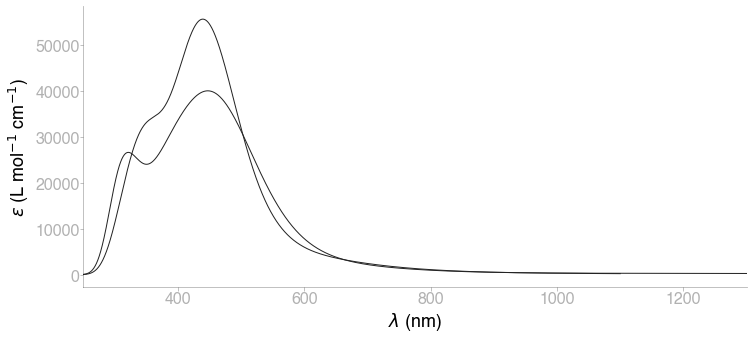

In [10]:
com1 = load_complex('as10')
com2 = load_complex('p12')
f, ax = plot_uv(com1)
f, ax = plot_uv(com2, f=f, ax=ax)

No handles with labels found to put in legend.


[(18, 0.5106), (19, 0.3877), (23, 0.2367), (25, 0.1373), (21, 0.1193), (26, 0.103), (24, 0.0677), (16, 0.0513), (27, 0.051), (15, 0.043), (20, 0.0274), (30, 0.0231), (7, 0.0201), (31, 0.0148), (14, 0.0131), (1, 0.0127), (13, 0.0121), (35, 0.01), (33, 0.009), (11, 0.0084), (6, 0.0071), (2, 0.0051), (34, 0.0038), (17, 0.0029), (49, 0.0028), (29, 0.0025), (46, 0.0024), (50, 0.0024), (22, 0.0021), (28, 0.0017), (5, 0.0016), (9, 0.0016), (36, 0.0015), (4, 0.0012), (12, 0.0012), (39, 0.0012), (32, 0.0011), (40, 0.0011), (8, 0.001), (47, 0.001), (48, 0.0009), (45, 0.0007), (10, 0.0005), (38, 0.0005), (3, 0.0003), (41, 0.0003), (37, 0.0002), (43, 0.0002), (44, 0.0001), (42, 0.0)]
[18, 19, 23, 25]


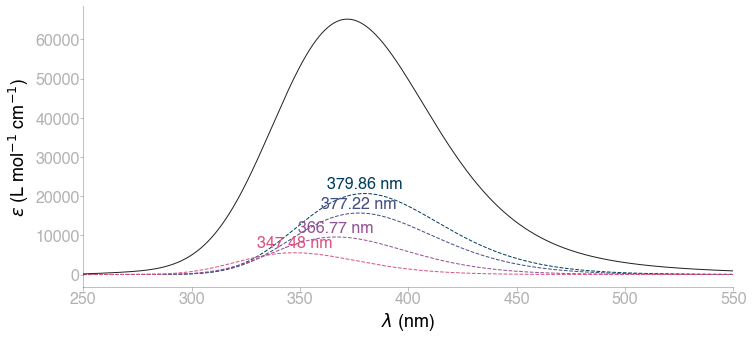

In [11]:
f, ax = plot_uv(system=com, states_to_plot=4)